In [1]:
! pwd

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/Maryland


In [2]:
%cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import json

from shapely.geometry import  MultiLineString, mapping, shape
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import angle, check_direction

# 1. EDA of XD segments & TMC segments (in Howard shapefile)

### 1.1 File I/O

In [4]:
# TMC & XD Geometry Data
'''
'tmc', 'miles', 'direction', 'type_x', 'type_y', 'road_order',
       'roadname', 'roadnumber', 'county', 'state', 'zip', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'geometry'
'''
gdf_hwd_tmc = gpd.read_file("/Volumes/Hao's WD/Howard/Shapefiles/tmc_shape_hwd.geojson")  # 1093 TMC segments in Howard, MD 

'''
'xd', 'miles', 'direction', 'bearing', 'frc', 'roadname', 'roadnumer',
       'county', 'state', 'zip', 'start_latitude', 'start_longitude',
       'end_latitude', 'end_longitude', 'geometry'
'''
gdf_hwd_xd = gpd.read_file("/Volumes/Hao's WD/Howard/Shapefiles/xd_shape_hwd_for_sjoin.geojson")  # 1772 of 4723 XD segments in Howard, MD; used for spatial join

# It is noted that those 1093 TMC segments and 1772 XD segments are also covered in speed data

In [59]:
gdf_hwd_tmc.columns

Index(['tmc', 'miles', 'direction', 'type_x', 'type_y', 'road_order',
       'roadname', 'roadnumber', 'county', 'state', 'zip', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'geometry'],
      dtype='object')

### 1.2 Visualization

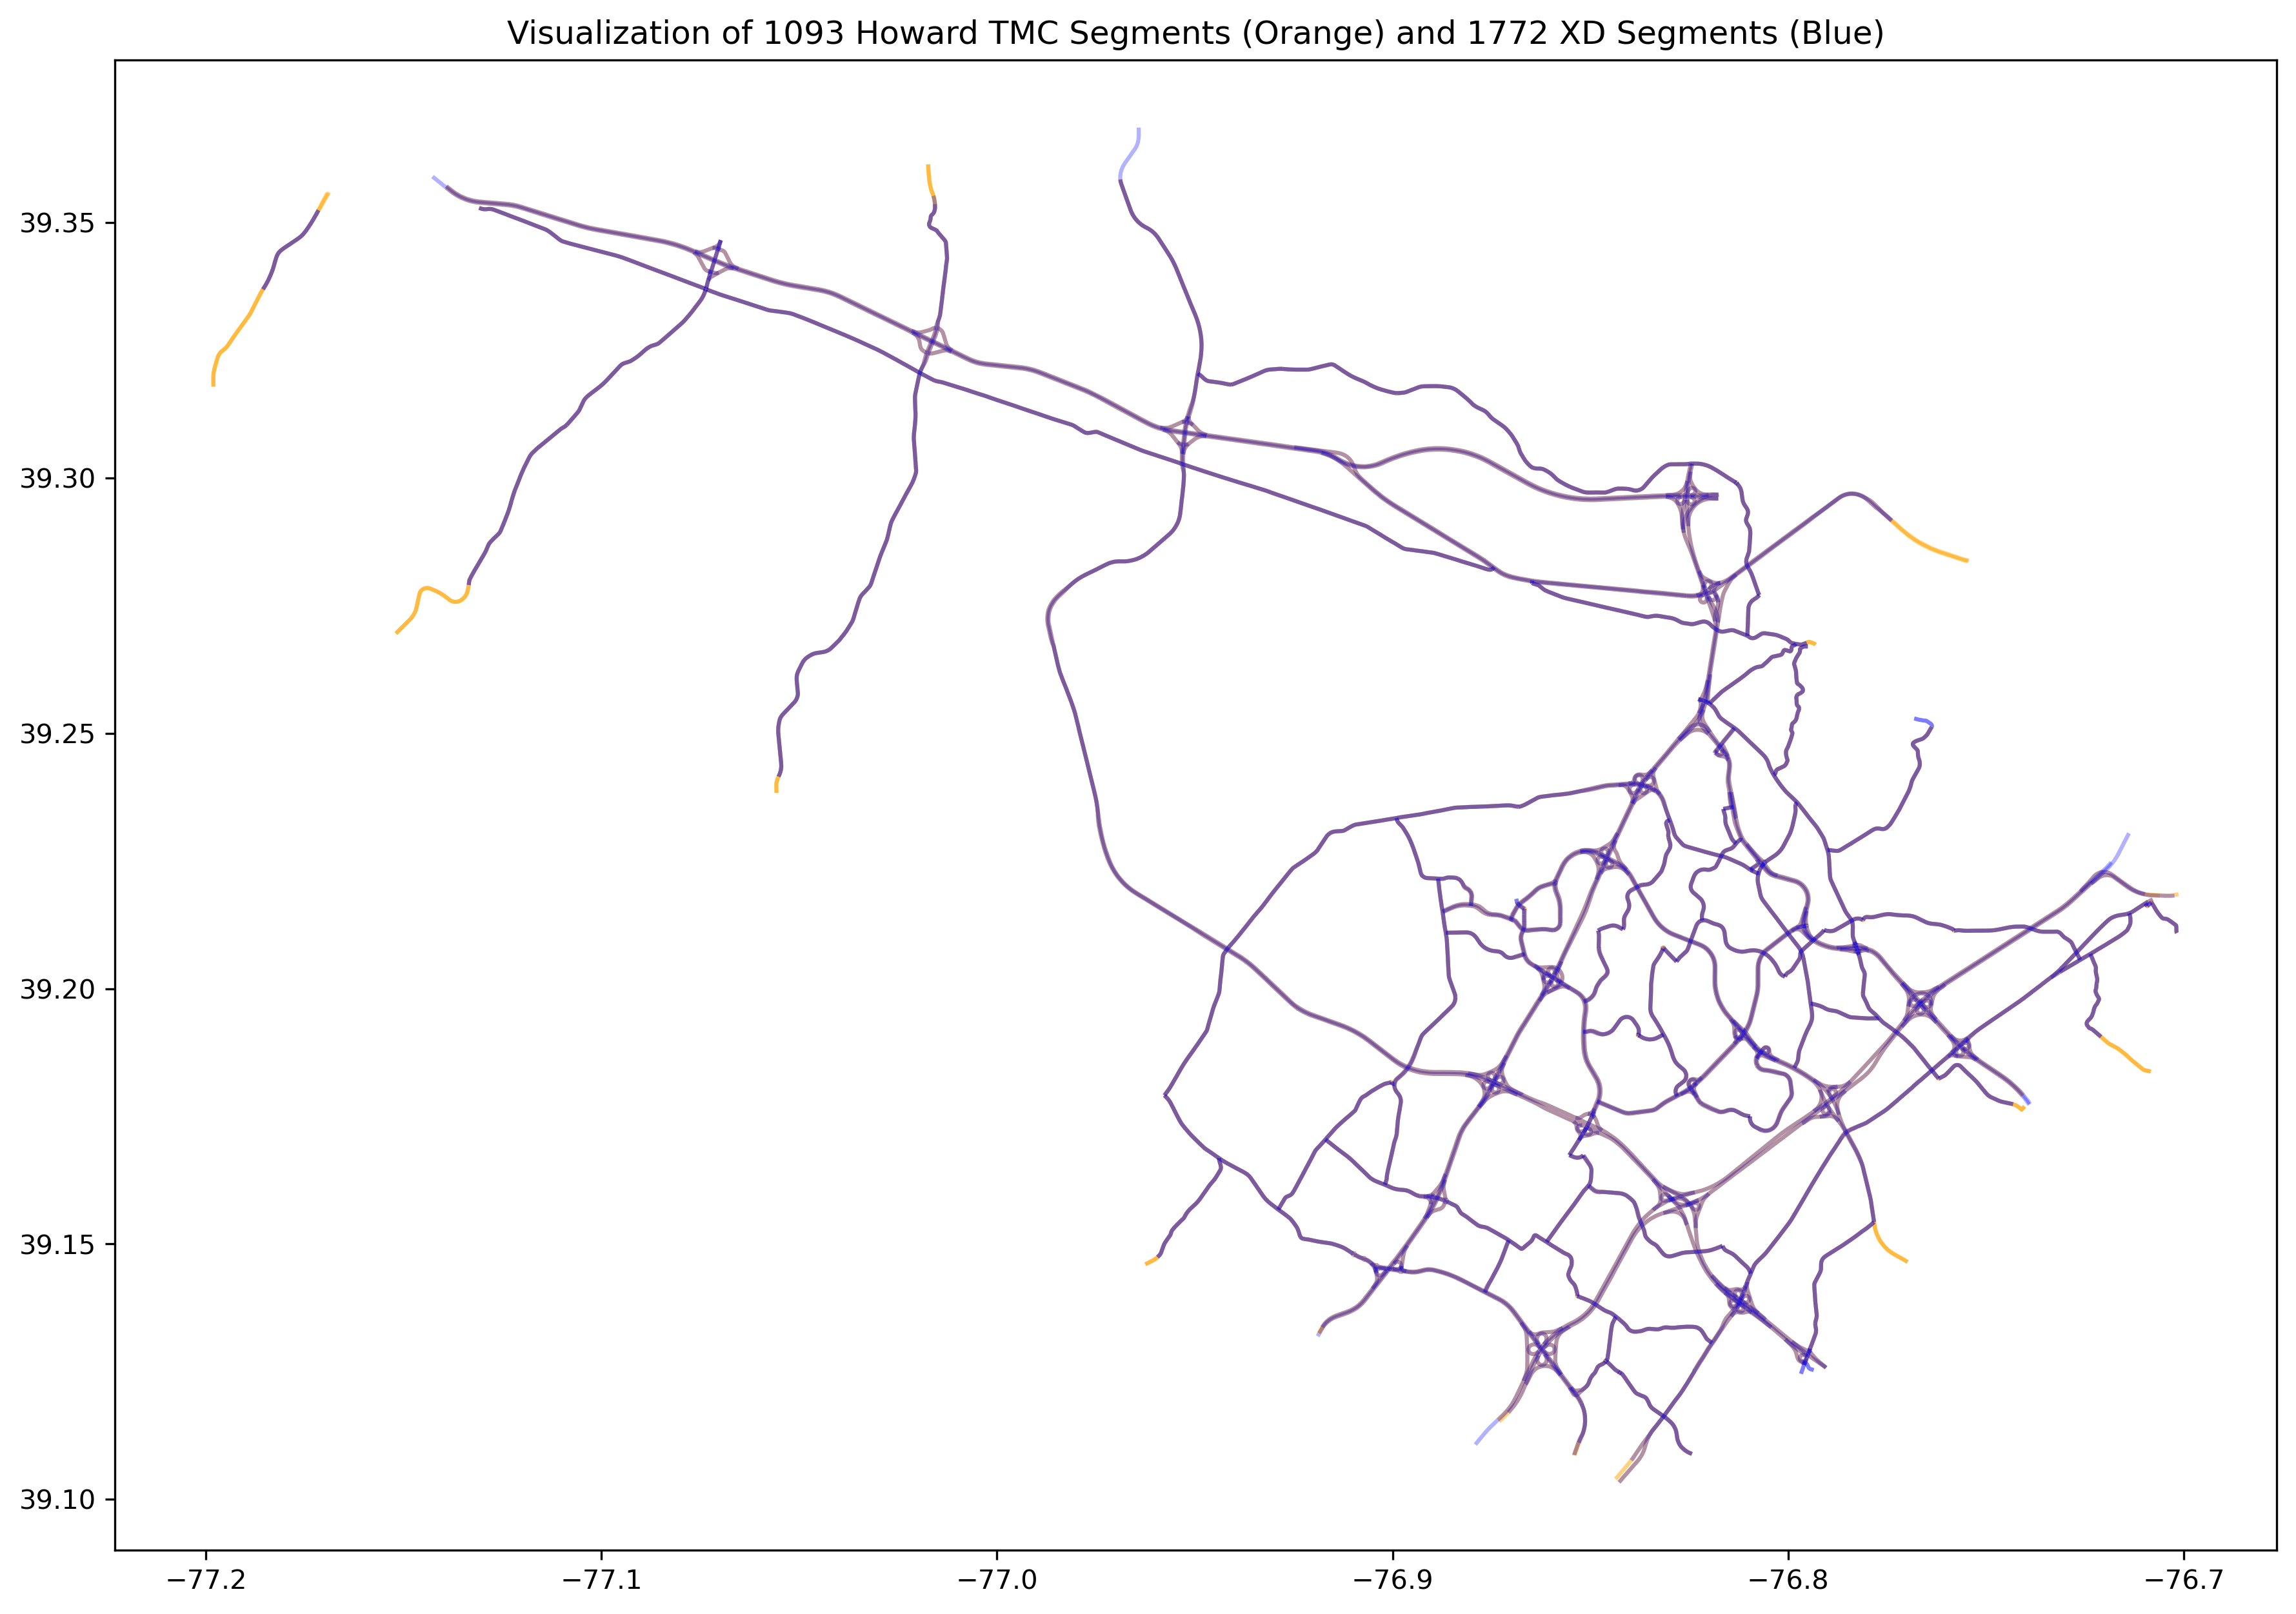

In [5]:
# (1) visualization of 1093 cranberry tmc segments
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1093 Howard TMC Segments (Orange) and 1772 XD Segments (Blue)")
gdf_hwd_tmc.plot(ax=ax, color="orange", alpha=0.5)
gdf_hwd_xd.plot(ax=ax, color="blue", alpha=0.3)
fig.savefig("./Maryland/viz_hwd_tmc_xd.jpg")

# 2. Match TMC and XD Segments

### 2.1 Create Buffer for Segments
Since the geometry of TMC segments and those of XD segments may not be perfectly aligned with one another, i.e. there may well be a tiny gap/shift between a TMC-XD pair even though they are supposed to be matched, here a buffer is created for each segment. The size of buffer ("distance" as specified in syntax of geopandas function) is manually defined. 

In [6]:
gdf_hwd_tmc_polygon = gdf_hwd_tmc.copy()
gdf_hwd_tmc_polygon["geometry"] = gdf_hwd_tmc.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)
gdf_hwd_tmc_polygon["area"] = gdf_hwd_tmc_polygon["geometry"].to_crs({'proj':'cea'}).area  # in unit of square meter

gdf_hwd_xd_polygon = gdf_hwd_xd.copy()
gdf_hwd_xd_polygon["geometry"] = gdf_hwd_xd.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)
gdf_hwd_xd_polygon["area"] = gdf_hwd_xd_polygon["geometry"].to_crs({'proj':'cea'}).area  # in unit of square meter

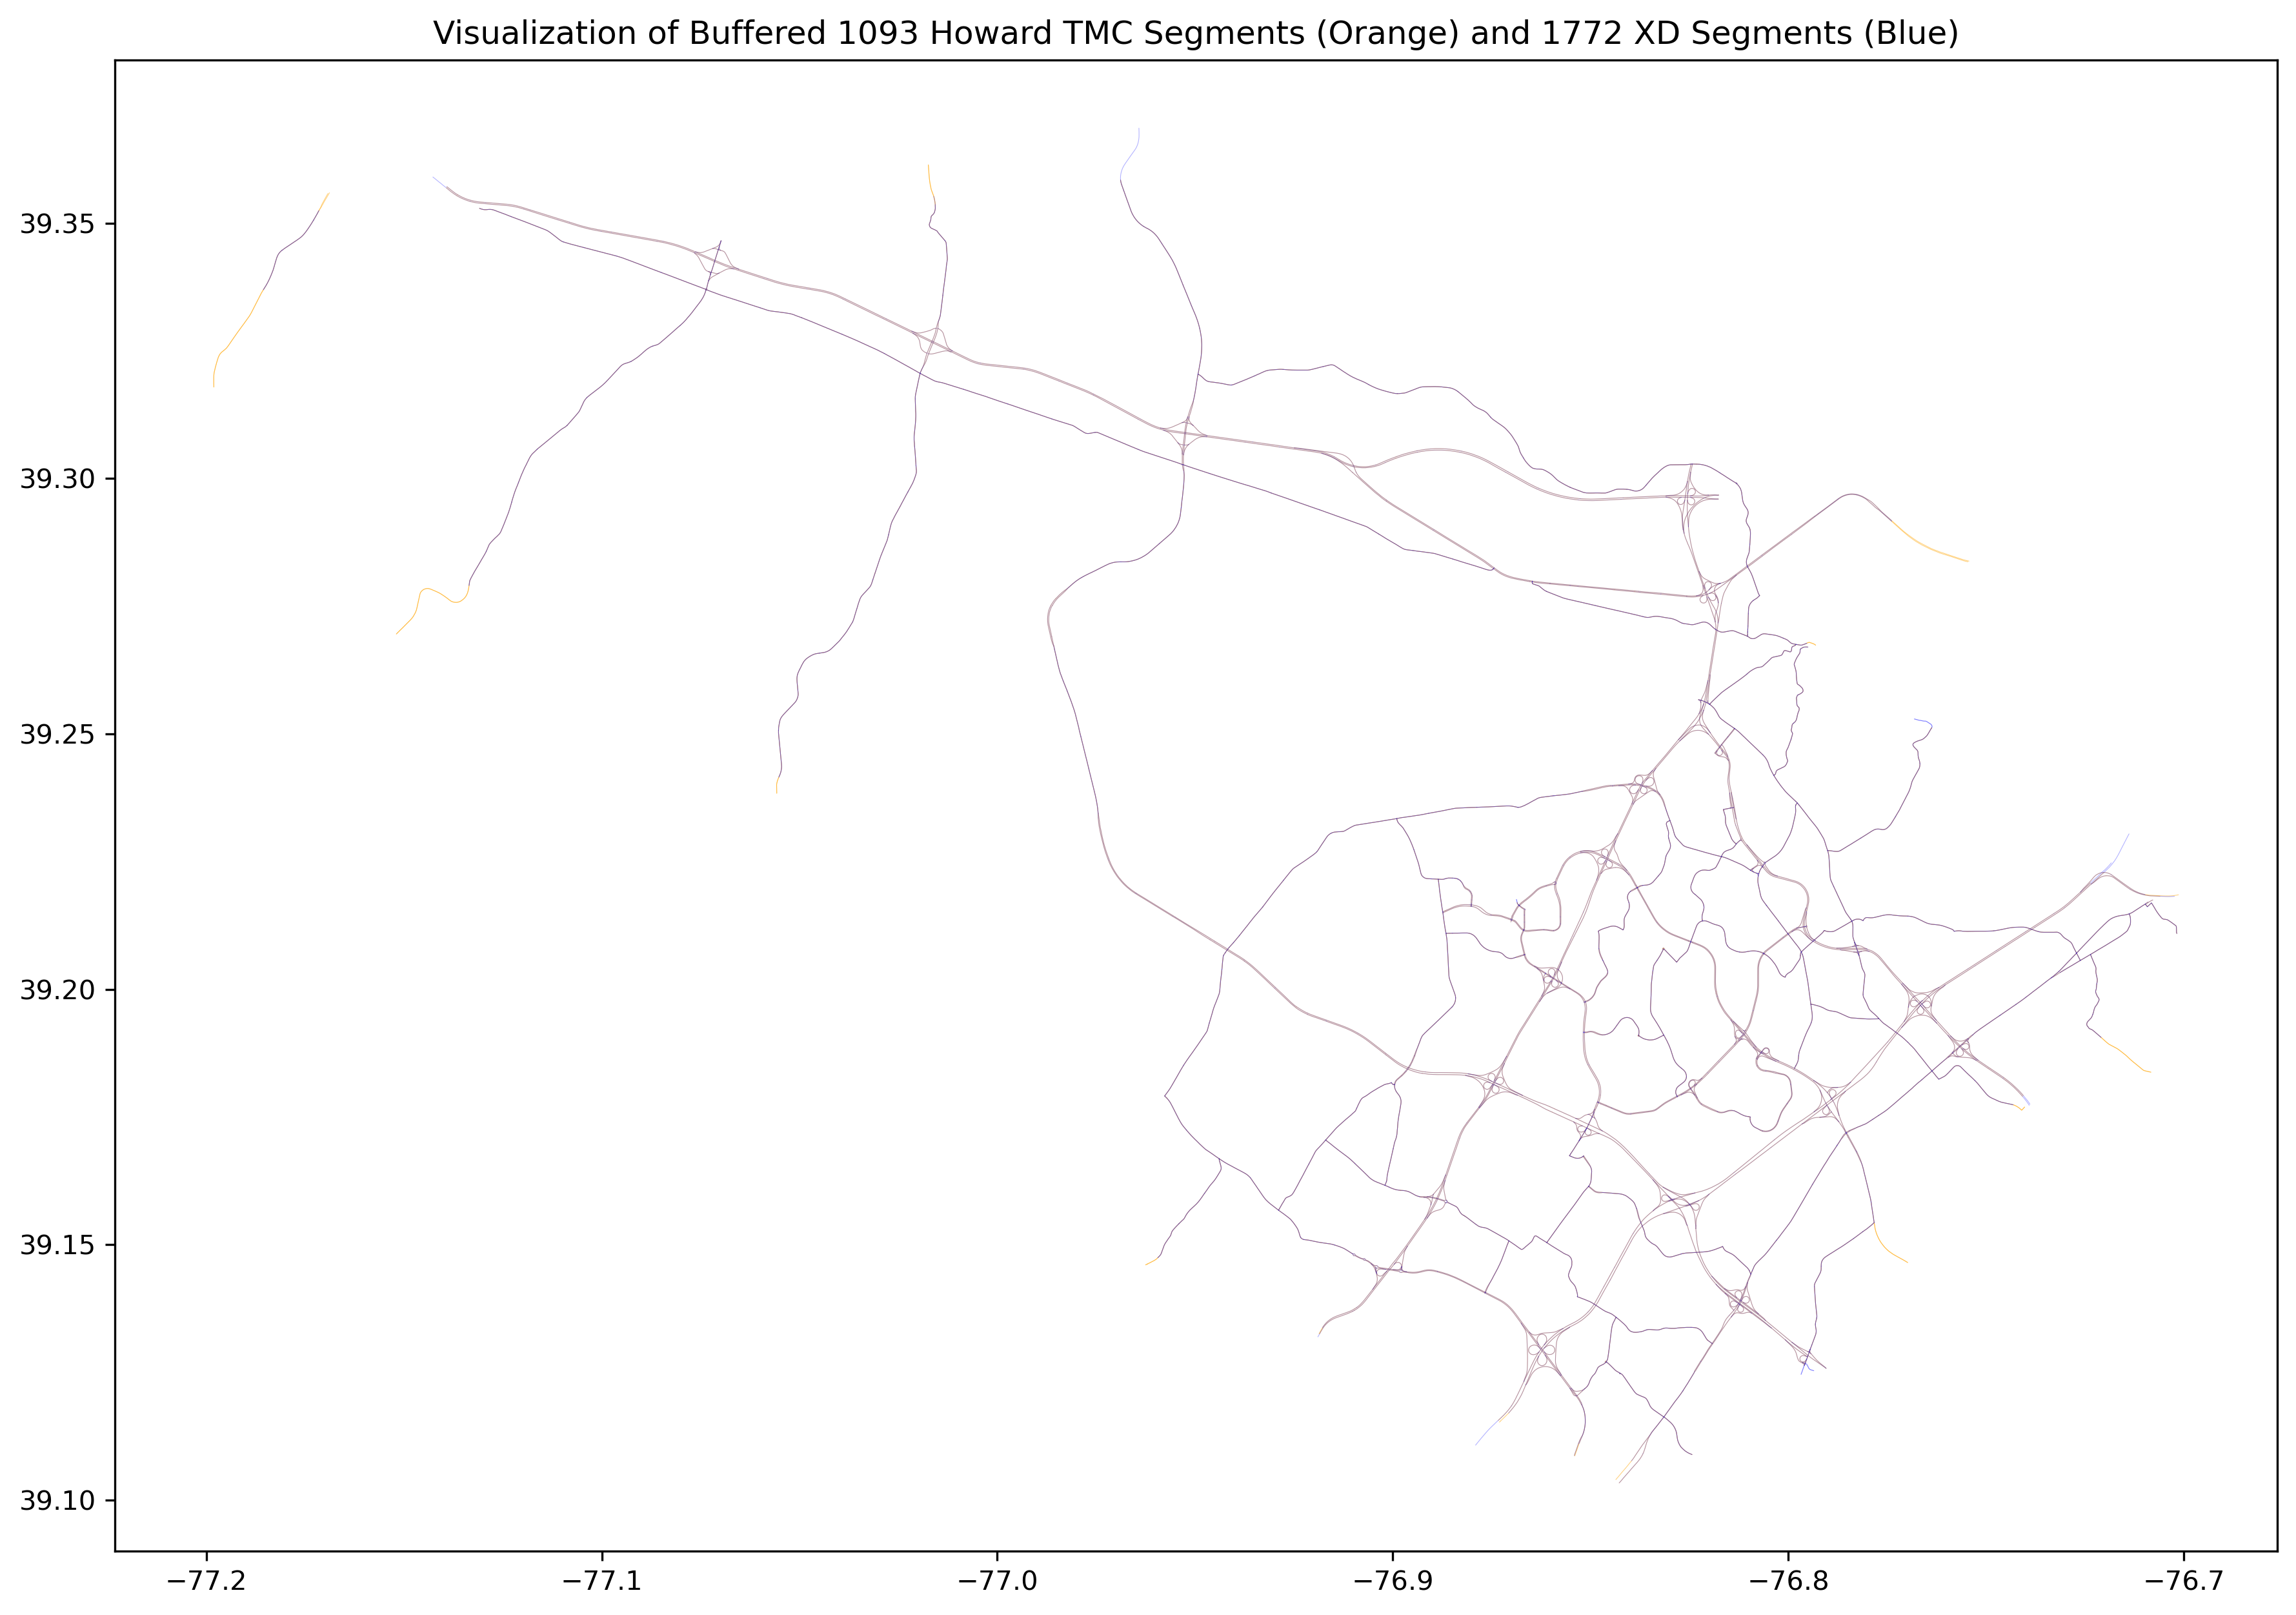

In [8]:
# Visualization of Buffered 1037 TMC (blue) and 1401 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Buffered 1093 Howard TMC Segments (Orange) and 1772 XD Segments (Blue)")
gdf_hwd_tmc_polygon.plot(ax=ax, color="orange", alpha=0.5)
gdf_hwd_xd_polygon.plot(ax=ax, color="blue", alpha=0.3)
fig.savefig("./Maryland/viz_hwd_buffered_tmc_xd.jpg")

### 2.2 Spatial Join

In [27]:
# we would like to retain all tmc segments, therefore we do left join here
xd_to_tmc = gpd.overlay(df1=gdf_hwd_tmc_polygon, df2=gdf_hwd_xd_polygon, how="intersection") # 1090 TMC, 1772 XD, shape (8407, 32)

In [28]:
xd_to_tmc["overlap_area"] = xd_to_tmc["geometry"].to_crs({'proj':'cea'}).area

<AxesSubplot: title={'center': 'Visualization of Overlapping Area (Red) between 1090 Howard TMC Segments (Orange) and 1772 XD Segments (Blue)'}>

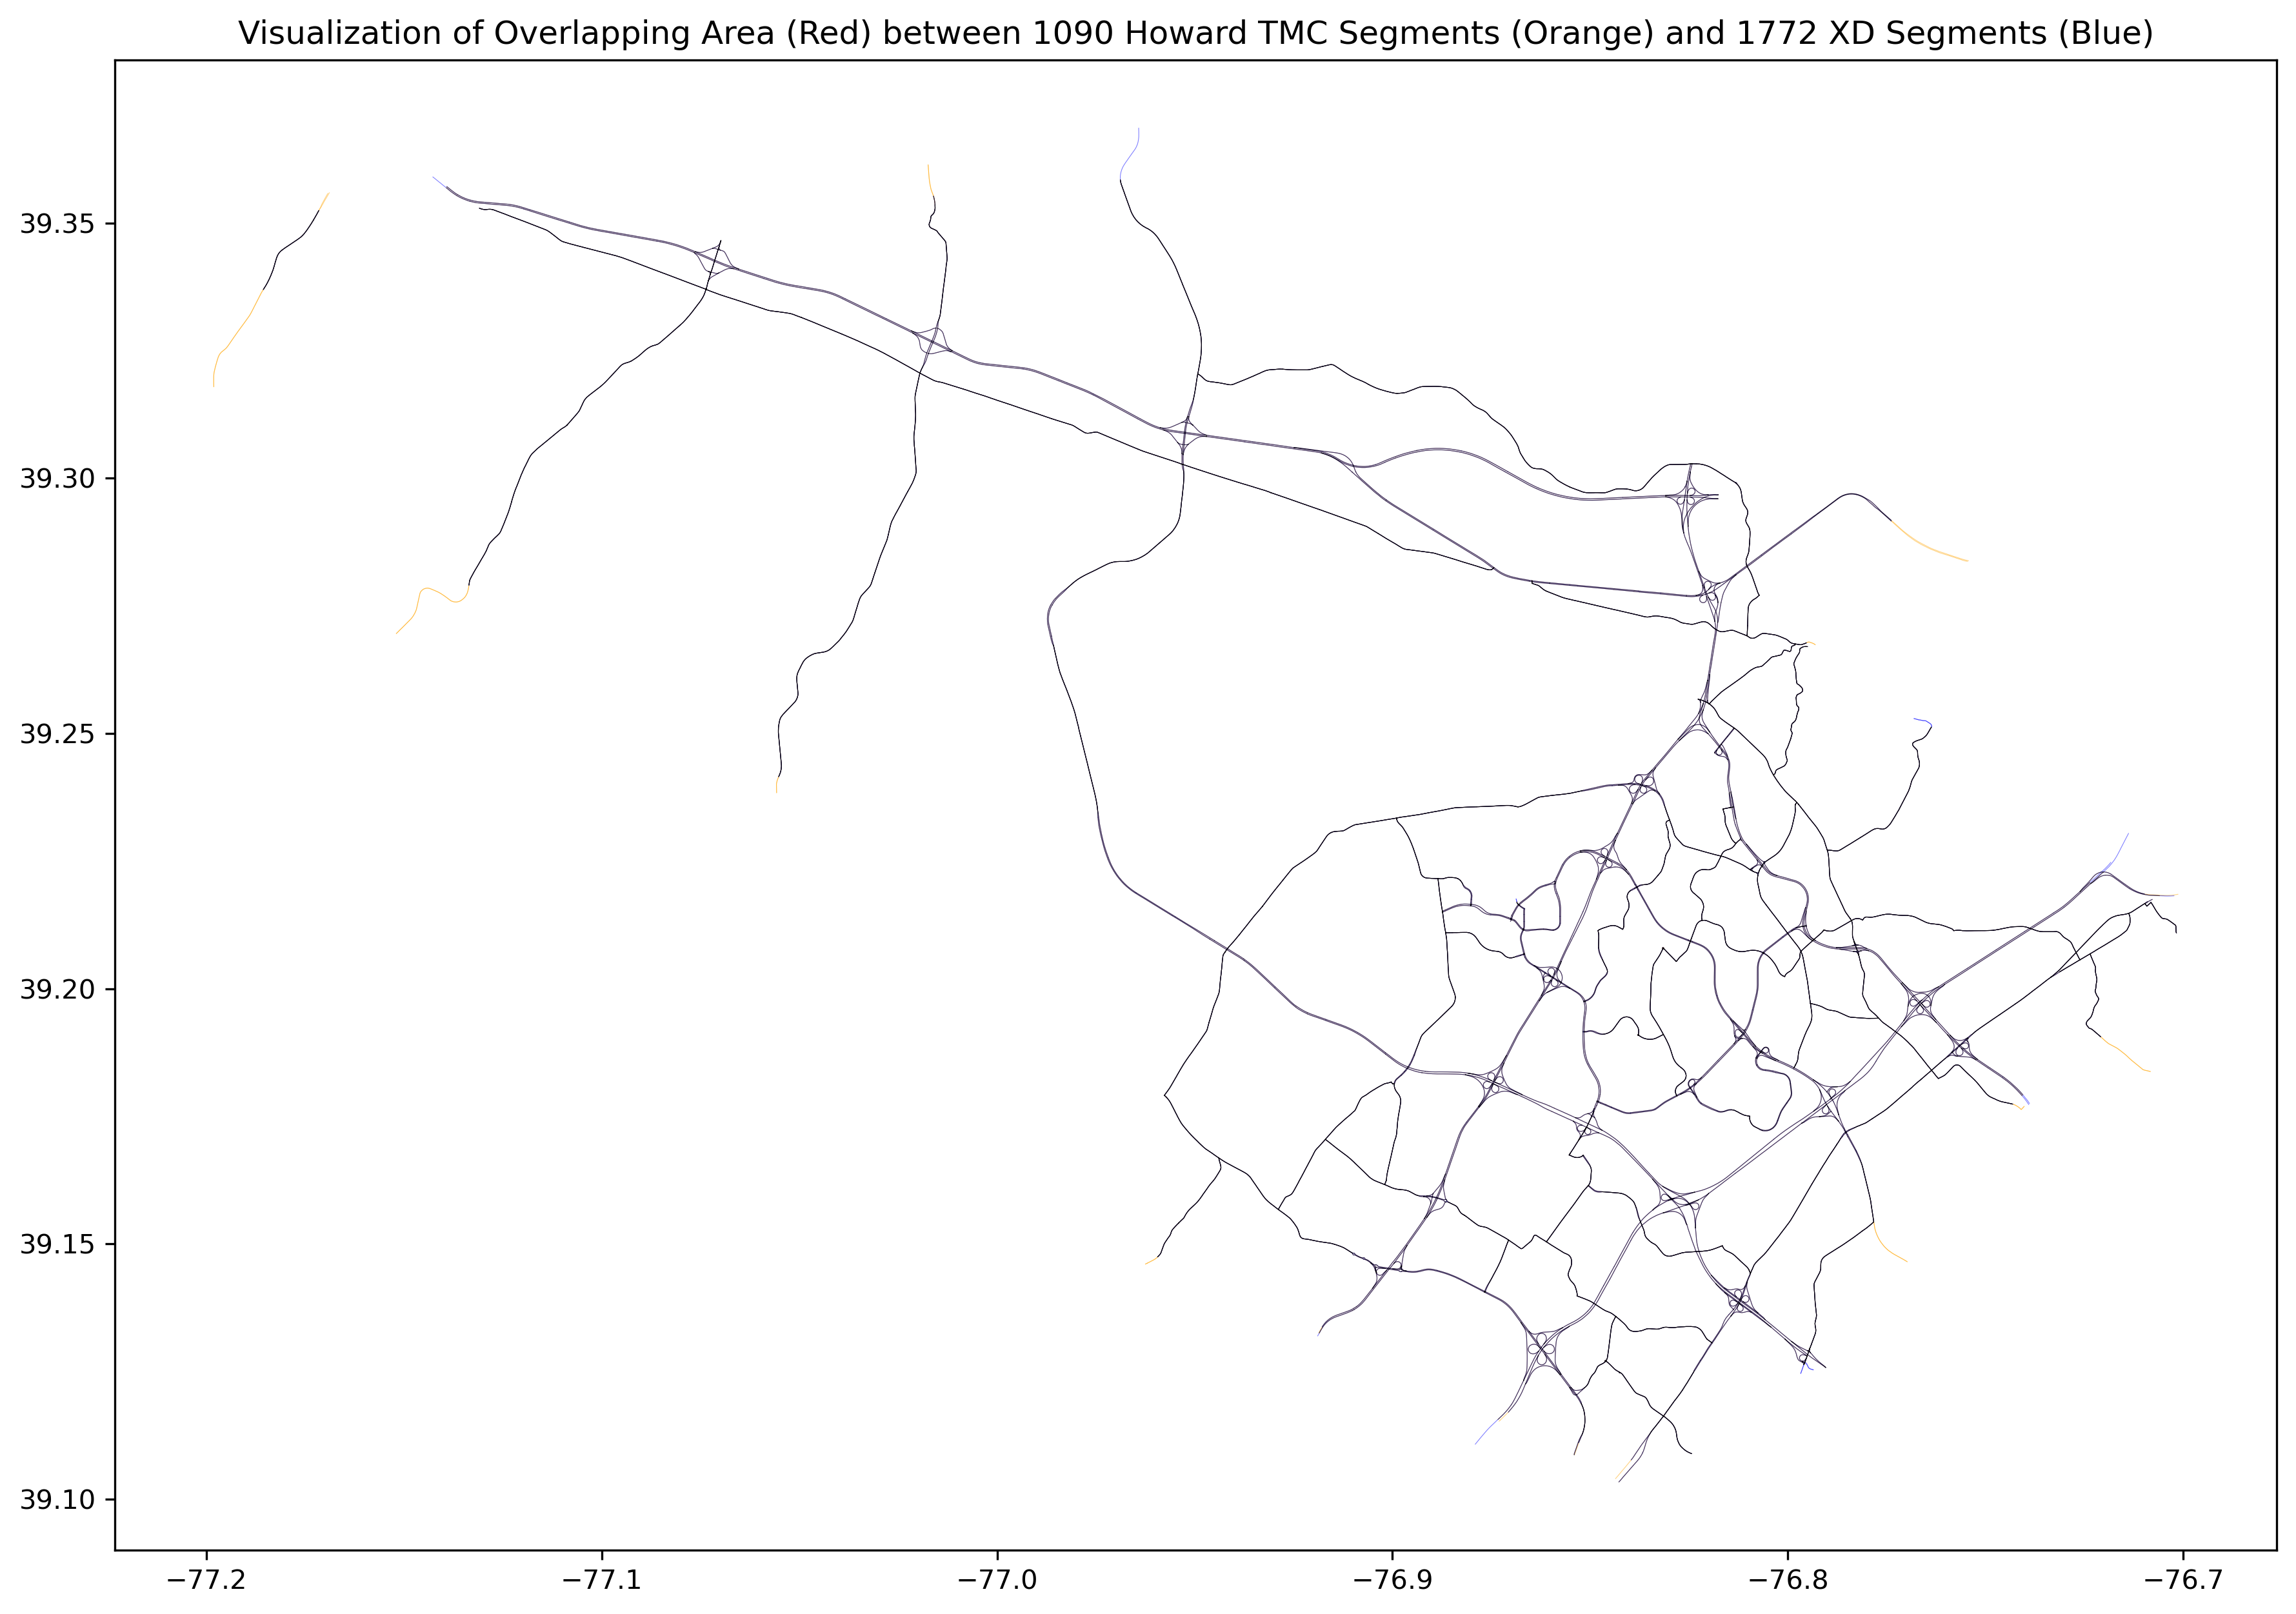

In [29]:
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Overlapping Area (Red) between 1090 Howard TMC Segments (Orange) and 1772 XD Segments (Blue)")
gdf_hwd_tmc_polygon.plot(ax=ax, color="orange", alpha=0.5)
gdf_hwd_xd_polygon.plot(ax=ax, color="blue", alpha=0.5)
xd_to_tmc.plot(ax=ax, color="black", alpha=0.5)


In [30]:
'''
'tmc', 'miles_1', 'direction_1', 'type_x', 'type_y', 'road_order',
       'roadname_1', 'roadnumber', 'county_1', 'state_1', 'zip_1',
       'start_latitude_1', 'start_longitude_1', 'end_latitude_1',
       'end_longitude_1', 'area_1', 'xd', 'miles_2', 'direction_2', 'bearing',
       'frc', 'roadname_2', 'roadnumer', 'county_2', 'state_2', 'zip_2',
       'start_latitude_2', 'start_longitude_2', 'end_latitude_2',
       'end_longitude_2', 'area_2', 'geometry', 'overlap_area'],
      dtype='object'
'''
xd_to_tmc

,tmc,miles_1,direction_1,type_x,type_y,road_order,roadname_1,roadnumber,county_1,state_1,...,county_2,state_2,zip_2,start_latitude_2,start_longitude_2,end_latitude_2,end_longitude_2,area_2,geometry,overlap_area
0,110N55328,0.012617,SOUTHBOUND,P1.11,Feature,1.0,COLUMBIA 100 PKWY,None,HOWARD,MD,...,HOWARD,MD,21045,39.235190,-76.816400,39.228440,-76.813160,12824.655339,"POLYGON ((-76.81634 39.23494, -76.81645 39.235...",434.367950
1,110-55327,0.477524,SOUTHBOUND,P1.11,Feature,2.0,COLUMBIA 100 PKWY,None,HOWARD,MD,...,HOWARD,MD,21045,39.235190,-76.816400,39.228440,-76.813160,12824.655339,"POLYGON ((-76.81625 39.23497, -76.81622 39.234...",12024.676939
2,110-53857,0.339315,SOUTHBOUND,P1.11,Feature,2.0,CENTRE PARK DR,None,HOWARD,MD,...,HOWARD,MD,21045,39.235190,-76.816400,39.228440,-76.813160,12824.655339,"POLYGON ((-76.81323 39.22848, -76.81323 39.228...",177.383945
3,110N55327,0.019471,SOUTHBOUND,P1.11,Feature,3.0,COLUMBIA 100 PKWY,None,HOWARD,MD,...,HOWARD,MD,21045,39.235190,-76.816400,39.228440,-76.813160,12824.655339,"POLYGON ((-76.81309 39.22840, -76.81322 39.228...",605.289902
4,110N55330,0.030078,WESTBOUND,P1.11,Feature,3.0,EXECUTIVE PARK DR,None,HOWARD,MD,...,HOWARD,MD,21045,39.235190,-76.816400,39.228440,-76.813160,12824.655339,"POLYGON ((-76.81649 39.23518, -76.81645 39.235...",148.126932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,110+04419,2.051002,NORTHBOUND,P1.3,Feature,686.0,I-95 N,I-95,HOWARD,MD,...,HOWARD,MD,20794,39.143080,-76.845030,39.150638,-76.839741,14948.295234,"POLYGON ((-76.84456 39.14390, -76.84456 39.143...",14948.270264
8403,110+04420,1.578560,NORTHBOUND,P1.3,Feature,688.0,I-95 N,I-95,HOWARD,MD,...,HOWARD,MD,20794,39.163812,-76.813322,39.169041,-76.804352,15119.448099,"POLYGON ((-76.81138 39.16501, -76.81138 39.165...",15119.373419
8404,110+04422,2.405895,NORTHBOUND,P1.1,Feature,692.0,I-95 N,I-95,HOWARD,MD,...,HOWARD,MD,21075,39.212116,-76.737654,39.215943,-76.730145,12119.037728,"POLYGON ((-76.73335 39.21434, -76.73156 39.215...",12118.471668
8405,110+04422,2.405895,NORTHBOUND,P1.1,Feature,692.0,I-95 N,I-95,HOWARD,MD,...,HOWARD,MD,21075,39.204585,-76.752779,39.208349,-76.745216,12120.329259,"POLYGON ((-76.75272 39.20470, -76.75272 39.204...",12120.302817


In [31]:
selected_xd_to_tmc = xd_to_tmc[["tmc", "xd", 'start_latitude_1', 'start_longitude_1', 'end_latitude_1', 'end_longitude_1', 'start_latitude_2', 'start_longitude_2', 'end_latitude_2', 'end_longitude_2', "direction_1", 'direction_2', 'area_1', 'area_2', 'overlap_area']]
selected_xd_to_tmc.columns = ["id_tmc", "id_xd", 'tmc_start_lat', 'tmc_start_long', 'tmc_end_lat', 'tmc_end_long', 'xd_start_lat', 'xd_start_long', 'xd_end_lat', 'xd_end_long', "direction_tmc", "direction_xd", 'area_tmc', 'area_xd', 'overlap_area']

# 3. Check on Overlapping Area

In [32]:
selected_xd_to_tmc["overlap_vs_tmc"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_tmc
selected_xd_to_tmc["overlap_vs_xd"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_xd

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_13998/321984553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["overlap_vs_tmc"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_tmc
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_13998/321984553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["overlap_vs_xd"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_xd


In [35]:
selected_xd_to_tmc.overlap_vs_tmc.describe(), selected_xd_to_tmc.overlap_vs_xd.describe()

(count    8.407000e+03
 mean     2.312560e-01
 std      3.169942e-01
 min      1.055390e-07
 25%      1.278633e-02
 50%      8.123630e-02
 75%      2.993929e-01
 max      1.000000e+00
 Name: overlap_vs_tmc, dtype: float64,
 count    8.407000e+03
 mean     3.559021e-01
 std      4.210482e-01
 min      2.025006e-07
 25%      1.711419e-02
 50%      1.011145e-01
 75%      9.999989e-01
 max      1.000000e+00
 Name: overlap_vs_xd, dtype: float64)

In [36]:
selected_xd_to_tmc

,id_tmc,id_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,direction_tmc,direction_xd,area_tmc,area_xd,overlap_area,overlap_vs_tmc,overlap_vs_xd
0,110N55328,133248799,39.23519,-76.81640,39.23501,-76.81636,39.235190,-76.816400,39.228440,-76.813160,SOUTHBOUND,S,434.367950,12824.655339,434.367950,1.000000,0.033870
1,110-55327,133248799,39.23501,-76.81636,39.22862,-76.81344,39.235190,-76.816400,39.228440,-76.813160,SOUTHBOUND,S,12024.676939,12824.655339,12024.676939,1.000000,0.937622
2,110-53857,133248799,39.22911,-76.81223,39.22601,-76.81689,39.235190,-76.816400,39.228440,-76.813160,SOUTHBOUND,S,8579.332231,12824.655339,177.383945,0.020676,0.013831
3,110N55327,133248799,39.22862,-76.81344,39.22844,-76.81316,39.235190,-76.816400,39.228440,-76.813160,SOUTHBOUND,S,605.289902,12824.655339,605.289902,1.000000,0.047197
4,110N55330,133248799,39.23528,-76.81585,39.23519,-76.81640,39.235190,-76.816400,39.228440,-76.813160,WESTBOUND,S,869.655774,12824.655339,148.126932,0.170328,0.011550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,110+04419,1310580152,39.13385,-76.85530,39.15607,-76.83154,39.143080,-76.845030,39.150638,-76.839741,NORTHBOUND,E,51315.121131,14948.295234,14948.270264,0.291303,0.999998
8403,110+04420,1310510304,39.15987,-76.82004,39.17363,-76.79651,39.163812,-76.813322,39.169041,-76.804352,NORTHBOUND,E,39510.594497,15119.448099,15119.373419,0.382666,0.999995
8404,110+04422,1310443876,39.20083,-76.76035,39.22058,-76.72344,39.212116,-76.737654,39.215943,-76.730145,NORTHBOUND,E,60118.695605,12119.037728,12118.471668,0.201576,0.999953
8405,110+04422,1310443799,39.20083,-76.76035,39.22058,-76.72344,39.204585,-76.752779,39.208349,-76.745216,NORTHBOUND,E,60118.695605,12120.329259,12120.302817,0.201606,0.999998


0    0.012617
Name: miles, dtype: float64
771    0.509711
Name: miles, dtype: float64


<AxesSubplot: title={'center': 'Visualization of Overlapping Area between TMC Segments (Orange) and XD Segments (Blue)'}>

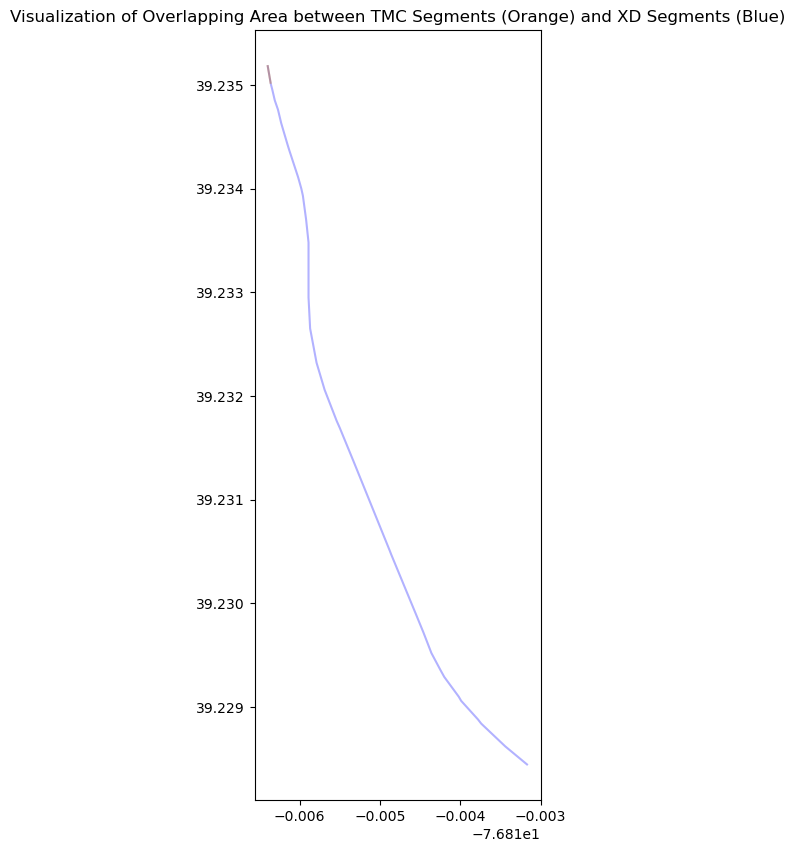

In [41]:
# viz of overlapping area
fig, ax = plt.subplots(1,figsize=(10,10))
ax.set_title("Visualization of Overlapping Area between TMC Segments (Orange) and XD Segments (Blue)")
curr_tmc = '110N55328'
curr_xd = 133248799
print(gdf_hwd_tmc[gdf_hwd_tmc.tmc == curr_tmc].miles)
print(gdf_hwd_xd[gdf_hwd_xd.xd == curr_xd].miles)
gdf_hwd_tmc[gdf_hwd_tmc.tmc == curr_tmc].plot(ax=ax, color="orange", alpha=0.5)
gdf_hwd_xd[gdf_hwd_xd.xd == curr_xd].plot(ax=ax, color="blue", alpha=0.3)

In [42]:
# select matching where overlapping area account for at least 50% of TMC and/or XD segments
selected_xd_to_tmc = selected_xd_to_tmc[(selected_xd_to_tmc.overlap_vs_tmc >= 0.5) | (selected_xd_to_tmc.overlap_vs_xd >= 0.5)] # 1090 TMC, 1764 XD, shape (2884, 17)

# 4. Checking on Direction

In [47]:
# compute angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["direction_matchness"] = selected_xd_to_tmc.apply(lambda x: check_direction(x.direction_tmc, x.direction_xd), axis=1)
selected_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.direction_matchness == 1].reset_index(drop=True) # 1068 TMC, 1716 XD, shape (2111, 19)
selected_xd_to_tmc["angle"] = selected_xd_to_tmc.apply(lambda x: angle(x.xd_start_lat, x.xd_start_long, x.tmc_start_lat, x.tmc_start_long, x.xd_end_lat, x.xd_end_long, x.tmc_end_lat, x.tmc_end_long), axis=1)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_13998/1810574786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["direction_matchness"] = selected_xd_to_tmc.apply(lambda x: check_direction(x.direction_tmc, x.direction_xd), axis=1)
/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/utils.py:130: RuntimeWarning: invalid value encountered in divide
  unit_v1 = v1/np.linalg.norm(v1)
/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/utils.py:131: RuntimeWarning: invalid value encountered in divide
  unit_v2 = v2/np.linalg.norm(v2)


In [52]:
# five number summary of angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["angle"].describe()

count    2110.000000
mean        0.126594
std         0.248573
min         0.000000
25%         0.001053
50%         0.024110
75%         0.100127
max         1.000000
Name: angle, dtype: float64

In [53]:
raw_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.angle < 0.5] # 1066 TMC, 1714 xd ids, shape (1926, 19)

In [57]:
raw_xd_to_tmc.to_csv("./Maryland/hwd_raw_xd_to_tmc.csv", index=False) # need further checking (step 4 below)

# 5. Manual Checking
- This step involves manual checking and comparison, the python script of which is covered in manual_check_hwd.py
- The final tmc-xd matching result has been saved in "./Maryland/hwd_xd_to_tmc.numbers" and "./Maryland/hwd_xd_to_tmc.csv"

# 6. Save Final Result as Dictionary

In [61]:
final_xd_to_tmc = pd.read_csv("./Maryland/hwd_xd_to_tmc.csv")

In [75]:
final_xd_to_tmc = final_xd_to_tmc.rename(columns={"id_xd":"id_xd_str"})
final_xd_to_tmc.id_xd_str = final_xd_to_tmc.id_xd_str.astype(str)

In [76]:
final_xd_to_tmc # 1066 TMC matched with 1711 XD, shape (1878, 20)

,Note,id_tmc,id_xd_str,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,direction_tmc,direction_xd,area_tmc,area_xd,overlap_area,overlap_vs_tmc,overlap_vs_xd,direction_matchness,angle
0,XD比TMC小很多,110-53770,429097833,39.23604,-76.79813,39.22304,-76.80729,39.22479,-76.80584,39.22485,-76.80596,SOUTHBOUND,O,27114.371515,317.109142,317.109142,0.011695,1.0,True,0.452200
1,XD比TMC小很多,110+12732,441095045,39.17219,-76.80653,39.18507,-76.80775,39.18388,-76.80382,39.18411,-76.80566,NORTHBOUND,W,34917.294991,2610.685197,2610.685197,0.074768,1.0,True,0.430356
2,XD比TMC小很多,110-12731,441095042,39.18498,-76.80795,39.17230,-76.80650,39.18394,-76.80568,39.18355,-76.80314,SOUTHBOUND,E,34592.685704,3583.714886,3583.714886,0.103597,1.0,True,0.415262
3,XD比TMC小很多,110P55341,429095687,39.24681,-76.81683,39.24585,-76.81781,39.24681,-76.81683,39.24666,-76.81675,LONG GATE PKWY NORTHBOUND AND MEADOWBROOK LN N...,S,3131.938725,399.272157,399.272157,0.127484,1.0,True,0.409240
4,XD比TMC小很多,110-12767,1310510238,39.18136,-76.89991,39.17048,-76.91698,39.18136,-76.89991,39.18172,-76.90034,SOUTHBOUND,W,31204.285208,980.589635,980.589603,0.031425,1.0,True,0.402493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,NaN,110+05141,1310239661,39.22030,-76.83841,39.22328,-76.84082,39.22030,-76.83841,39.22328,-76.84082,NORTHBOUND,N,6193.927555,6193.927555,6193.927555,1.000000,1.0,True,0.000000
1874,NaN,110P55477,1310440571,39.13898,-76.81189,39.13866,-76.81134,39.13898,-76.81189,39.13866,-76.81134,MD-32 WESTBOUND,E,6933.860213,6933.860213,6933.860213,1.000000,1.0,True,0.000000
1875,NaN,110P54258,1310511565,39.12446,-76.85737,39.13385,-76.85530,39.12446,-76.85737,39.13385,-76.85530,I-95 NORTHBOUND,N,18709.971838,18709.971838,18709.971838,1.000000,1.0,True,0.000000
1876,NaN,110+05025,1310358480,39.30117,-76.91018,39.29554,-76.90165,39.30117,-76.91018,39.29554,-76.90165,EASTBOUND,E,15057.418795,15057.418795,15057.418795,1.000000,1.0,True,0.000000


In [79]:
final_dict_xd_to_tmc = final_xd_to_tmc.groupby("id_tmc").apply(lambda x: x.id_xd_str.tolist()).to_dict()
final_dict_tmc_to_xd = final_xd_to_tmc.groupby("id_xd_str").apply(lambda x: x.id_tmc.tolist()).to_dict()

In [86]:
pickle.dump(final_xd_to_tmc, open("./Maryland/df_hwd_xd_to_tmc.pkl", "wb"))
pickle.dump(final_dict_xd_to_tmc, open("./Maryland/dict_hwd_xd_to_tmc.pkl", "wb"))
pickle.dump(final_dict_tmc_to_xd, open("./Maryland/dict_hwd_tmc_to_xd.pkl", "wb"))

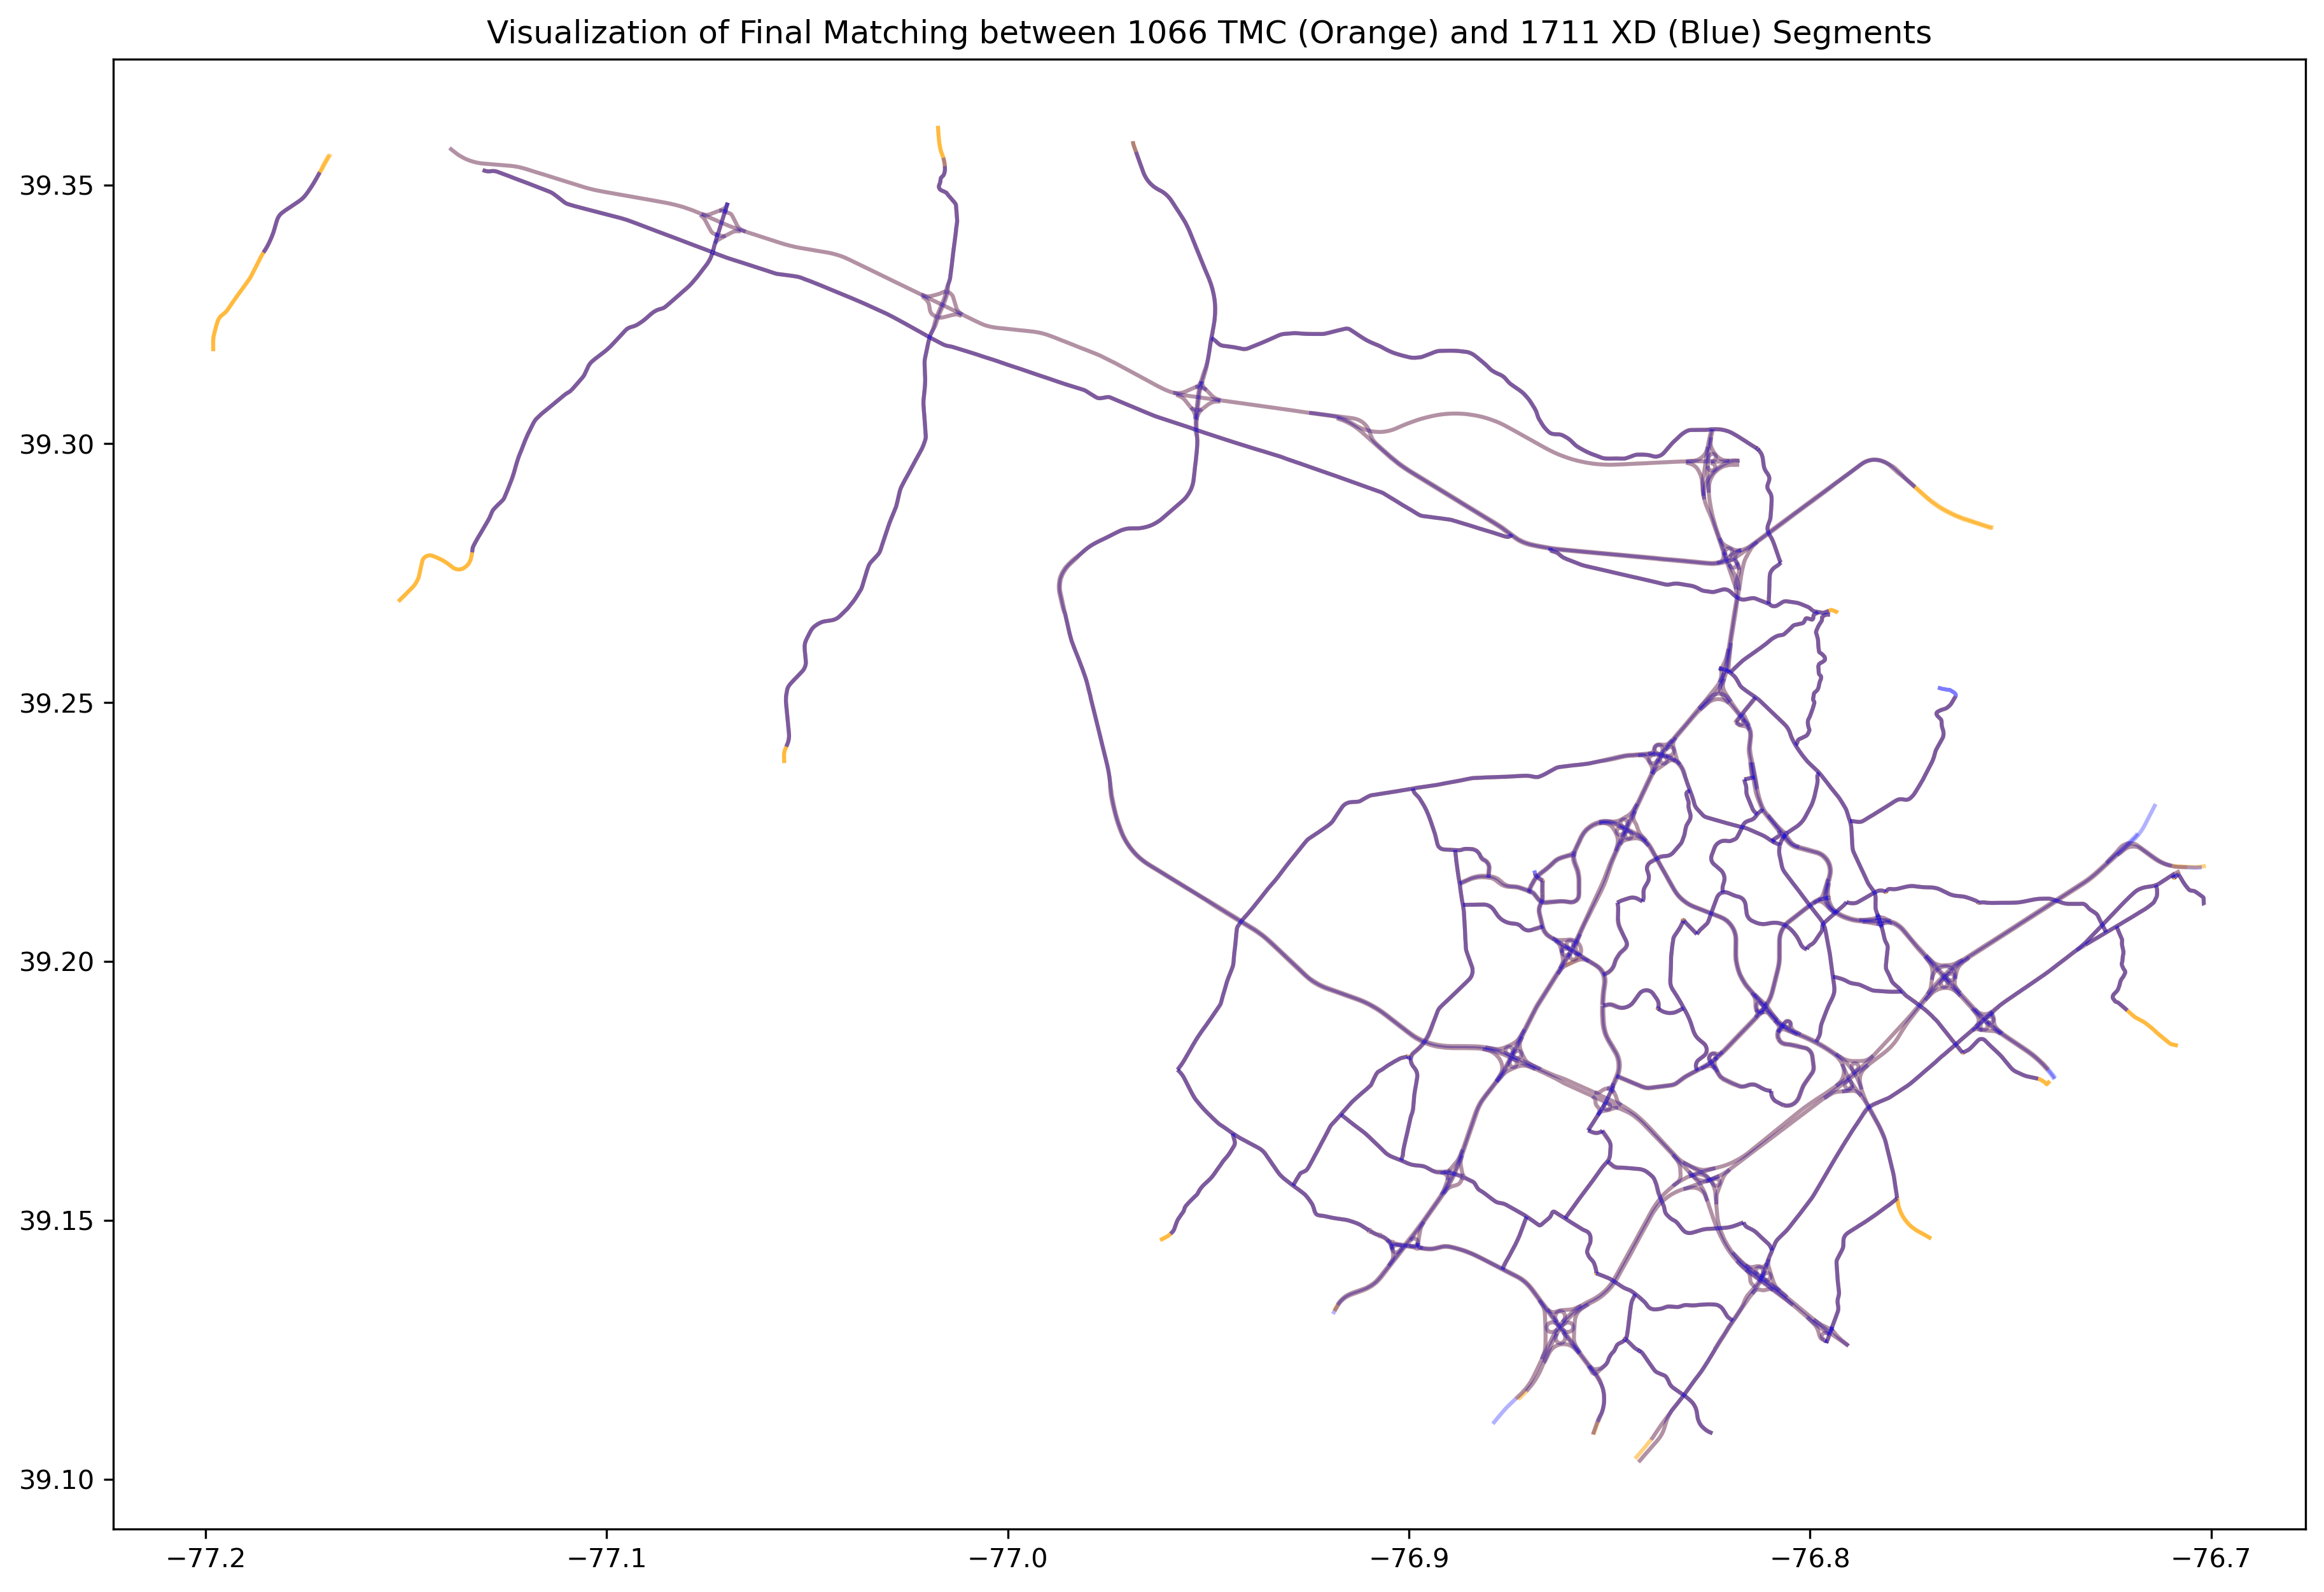

In [84]:
# Visualization of Matched 1066 TMC (Orange) and 1711 XD (Blue) Segments (Buffered with radius 10)
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Final Matching between 1066 TMC (Orange) and 1711 XD (Blue) Segments")
gdf_hwd_tmc[gdf_hwd_tmc.tmc.isin(set(final_xd_to_tmc.id_tmc))].plot(ax=ax, color="orange", alpha=0.5)
gdf_hwd_xd[gdf_hwd_xd.xd.astype(str).isin(set(final_xd_to_tmc.id_xd_str))].plot(ax=ax, color="blue", alpha=0.3)
fig.savefig("./Maryland/viz_hwd_final_xd_to_tmc.jpg")